In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
import tqdm

In [3]:
sys.path.append("../")

In [4]:
from Transformers import ChannelsFirst, ToTensor, Rescale, Cut, splitter_train_val_test

In [5]:
from DataSets import UNetDatasetFromFolders

In [6]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT

In [7]:
root_folder = os.path.join(data_dir, "dataset")

In [8]:
composed = transforms.Compose([Cut(), Rescale(.25), ChannelsFirst(), ToTensor()])

In [9]:
complete_dataset = UNetDatasetFromFolders(root_folder, transform=composed)

data_loader = DataLoader(complete_dataset, batch_size=16, shuffle=True, num_workers=4)

In [10]:
data_loaders, data_lengths = splitter_train_val_test(complete_dataset, 
                                                     validation_split=0.2,
                                                     test_split = 0.2, 
                                                     batch=16, 
                                                     workers=4)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [13]:
model = cUNet(out_size=1)

In [14]:
criterion_mask = dice_loss

In [15]:
criterion_class = nn.MSELoss()

In [16]:
model.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [17]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [18]:
epochs = 50

In [19]:
coeff_mask = 0.75

In [20]:
data_lengths

{'train': 5760, 'val': 1440, 'test': 1800}

In [21]:
5760+1440+1800

9000

In [22]:
for epoch in tqdm.tqdm(range(epochs)):
    print("Epoch {}/{}\n".format(epoch+1, epochs))
    print('-'* 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)
        else:
            model.train(False)
            
        running_loss = 0.0
        for i, batch in enumerate(data_loaders[phase]):
            inputs = batch['image'].float().to(device)
            labels_mask = batch['mask'].float().to(device)
            labels_dist = batch['dist'][...,np.newaxis].float().to(device)
            #print(inputs.is_cuda, labels_mask.is_cuda, labels_dist.is_cuda)
            optimizer.zero_grad()
            out_mask, out_class  = model(inputs)
            #print(out_mask.is_cuda)
            #print(out_class.is_cuda)
            loss_mask = criterion_mask(out_mask, labels_mask)
            loss_class = criterion_class(out_class, labels_dist)
            loss = coeff_mask * loss_mask + (1-coeff_mask) * loss_class
            #print(loss_mask, loss_class)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # print statistics
            running_loss += loss.item()
        epoch_loss = running_loss / data_lengths[phase]
        print('{} Loss: {:.4f}'.format(phase, epoch_loss))
print('Finished Training')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50

----------
train Loss: 2.3305


  2%|▏         | 1/50 [08:22<6:50:32, 502.71s/it]

val Loss: 2.1587
Epoch 2/50

----------


KeyboardInterrupt: 

In [24]:
model_name = "../model/trained_cUNet_pytorch_regression_{}epochs_coeff_mask{}_validation.pkl".format(epochs, coeff_mask)

In [21]:
torch.save(model.state_dict(), model_name)

In [25]:
model_inference = cUNet(out_size=1)

In [26]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [26]:
test_dataset = UNetDataset(x_test, y_test, transform=composed, dist = dist_test)

test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

In [27]:
test_dataset = complete_dataset

In [28]:
test_data_loader = data_loader

In [29]:
model_inference = model.eval()

In [30]:
model_inference.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [31]:
import matplotlib.pyplot as plt

batch 1
1: true_dist: 25, pred_dist: [0.00246031]


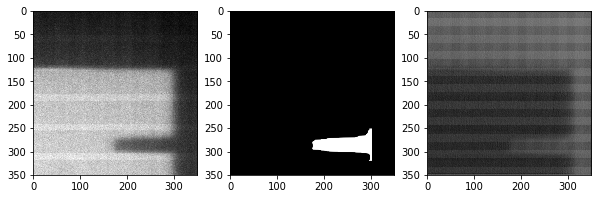

2: true_dist: 1, pred_dist: [0.00245709]


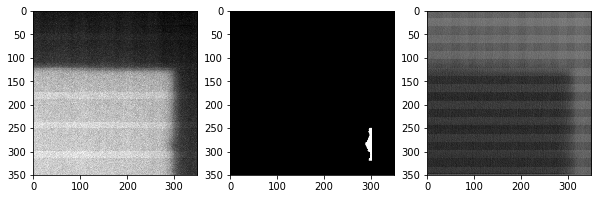

3: true_dist: 3, pred_dist: [0.0024577]


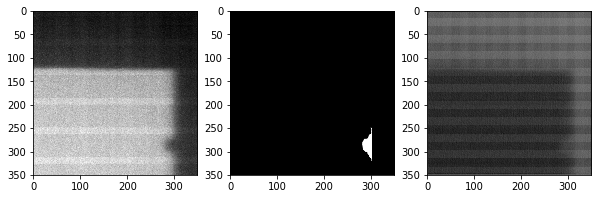

4: true_dist: 15, pred_dist: [0.00245712]


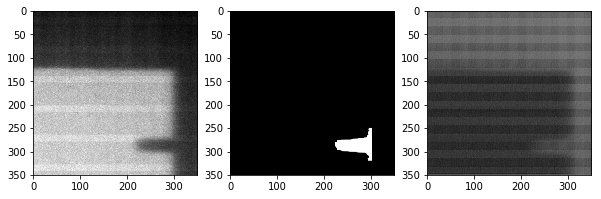

5: true_dist: 30, pred_dist: [0.00246082]


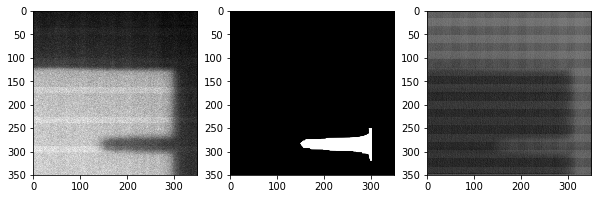

6: true_dist: 10, pred_dist: [0.00245914]


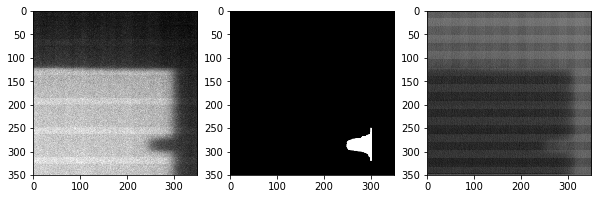

7: true_dist: 1, pred_dist: [0.00245684]


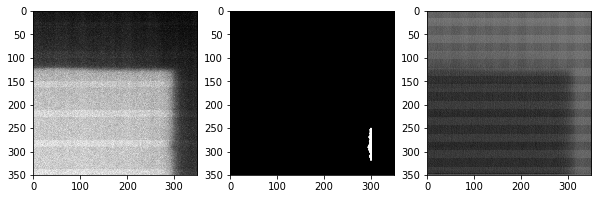

8: true_dist: 10, pred_dist: [0.00245838]


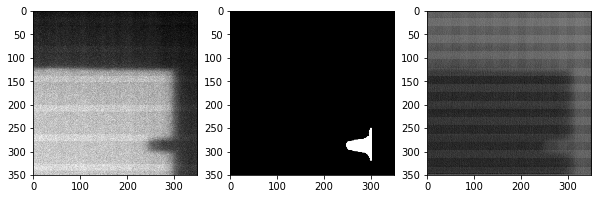

9: true_dist: 25, pred_dist: [0.0024594]


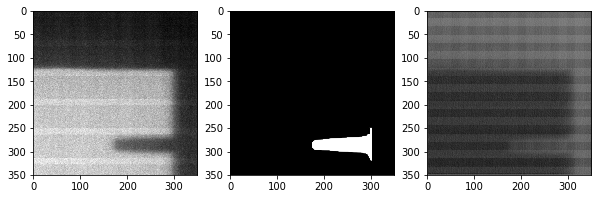

10: true_dist: 10, pred_dist: [0.00245964]


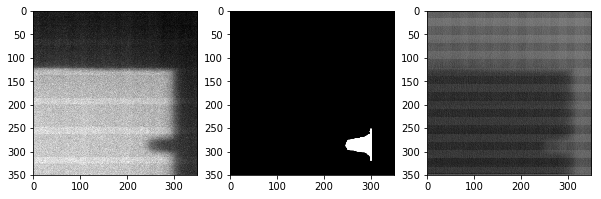

11: true_dist: 3, pred_dist: [0.00245835]


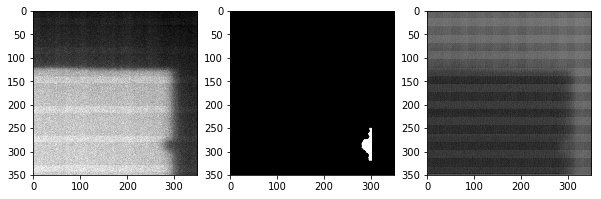

12: true_dist: 10, pred_dist: [0.00246036]


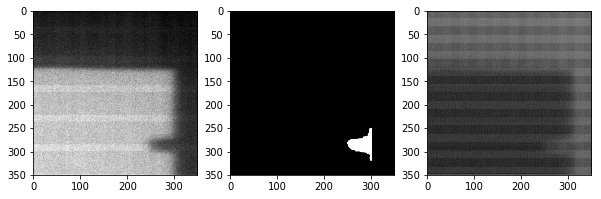

13: true_dist: 3, pred_dist: [0.00245754]


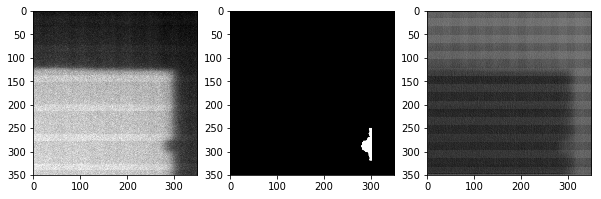

14: true_dist: 35, pred_dist: [0.00246048]


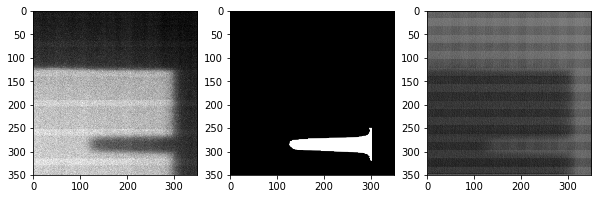

15: true_dist: 30, pred_dist: [0.00245965]


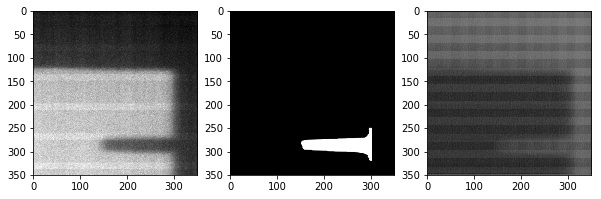

16: true_dist: 35, pred_dist: [0.00245899]


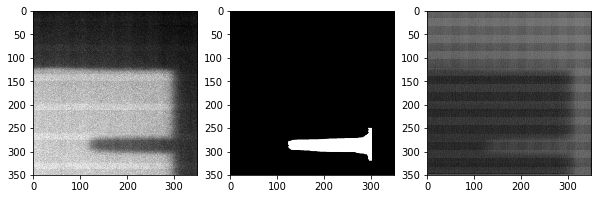

batch 2
1: true_dist: 3, pred_dist: [0.00245799]


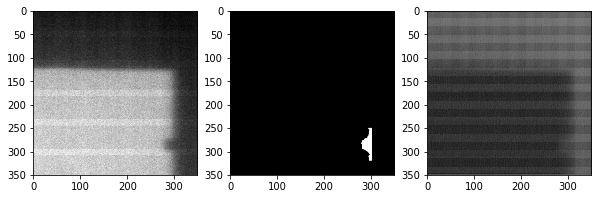

2: true_dist: 30, pred_dist: [0.00245959]


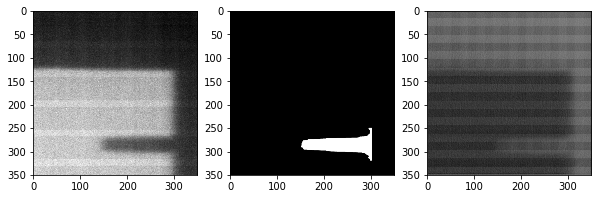

3: true_dist: 2, pred_dist: [0.00245855]


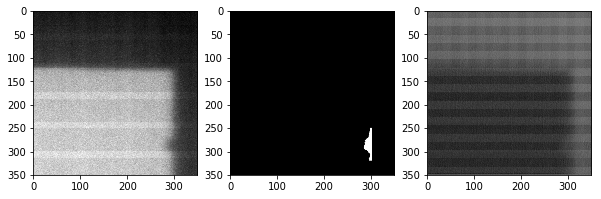

4: true_dist: 25, pred_dist: [0.00246023]


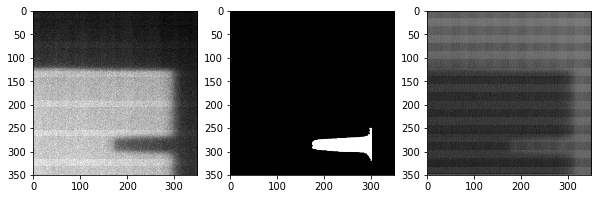

5: true_dist: 4, pred_dist: [0.00245838]


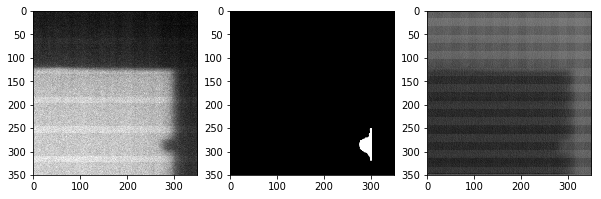

6: true_dist: 10, pred_dist: [0.00245997]


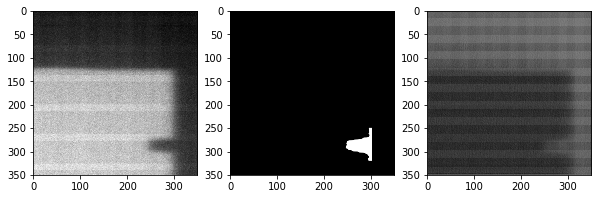

7: true_dist: 2, pred_dist: [0.00245751]


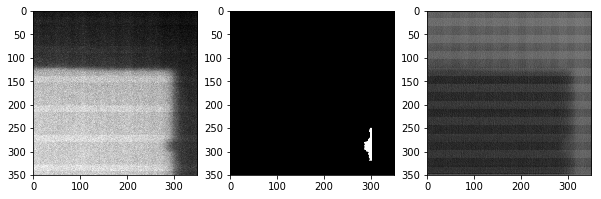

8: true_dist: 10, pred_dist: [0.0024583]


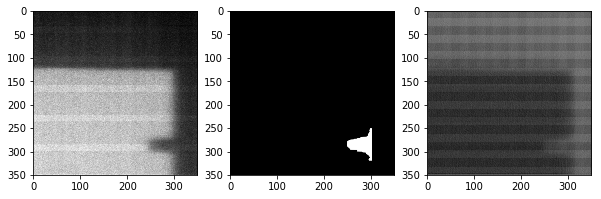

9: true_dist: 20, pred_dist: [0.00245829]


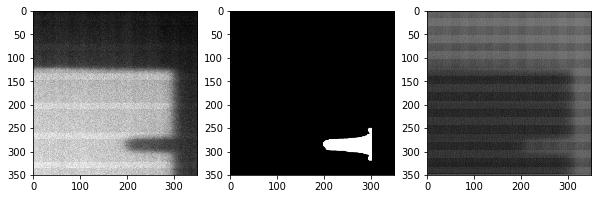

10: true_dist: 30, pred_dist: [0.00246268]


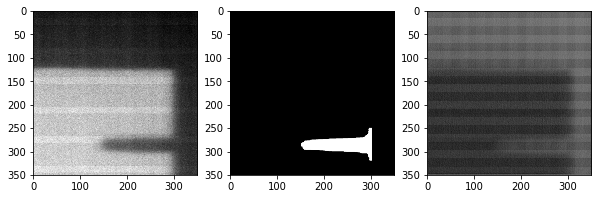

11: true_dist: 30, pred_dist: [0.00246291]


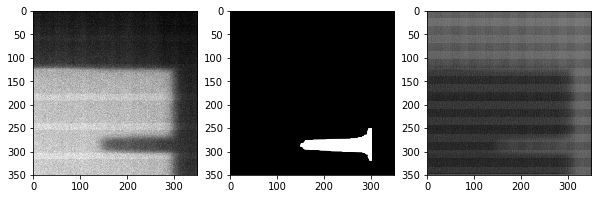

12: true_dist: 30, pred_dist: [0.00246266]


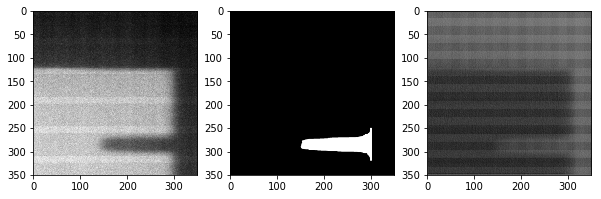

13: true_dist: 3, pred_dist: [0.00246179]


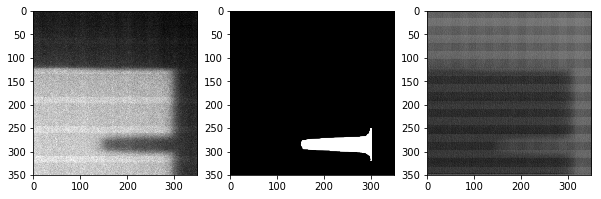

14: true_dist: 1, pred_dist: [0.00245682]


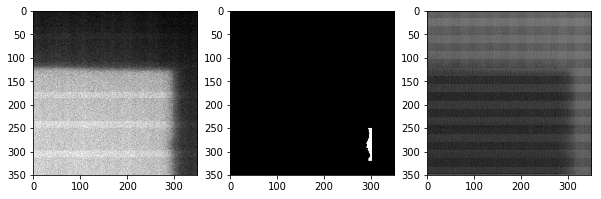

15: true_dist: 25, pred_dist: [0.00246096]


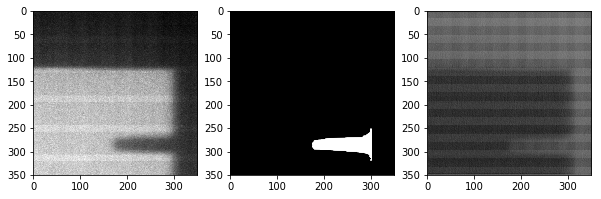

16: true_dist: 15, pred_dist: [0.00245811]


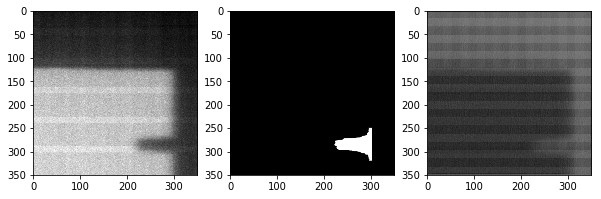

In [32]:
for i, batch in enumerate(data_loaders['test']):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_cl, pr_msk, pr_cl) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [33]:
y_test = []
y_pred = []
for i, batch in enumerate(test_data_loader):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_cl, pr_cl) in enumerate(zip(true_images,
                                                 true_dists.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        y_test.append(true_dist)
        y_pred.append(pred_dist)

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57
batch 58
batch 59
batch 60
batch 61
batch 62
batch 63
batch 64
batch 65
batch 66
batch 67
batch 68
batch 69
batch 70
batch 71
batch 72
batch 73
batch 74
batch 75
batch 76
batch 77
batch 78
batch 79
batch 80
batch 81
batch 82
batch 83
batch 84
batch 85
batch 86
batch 87
batch 88
batch 89
batch 90
batch 91
batch 92
batch 93
batch 94
batch 95
batch 96
batch 97
batch 98
batch 99
batch 100
batch 101
batch 102
batch 103
batch 104
batch 105
batch 106
batch 107
batch 108
batch 109
batch 110
batch 11

In [33]:
15*16

240

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [35]:
mean_squared_error(y_test, y_pred)

350.42866089195735

In [36]:
mean_absolute_error(y_test, y_pred)

14.497540878830529